In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

## Custom Functions

In [2]:
def data_viz(df, columns, target=None, type='bar'):
    num_of_cols = len(columns)
    
    if type=='hist':
        subplots = 4
    else:
        subplots = 2
        
    rows, remainder = divmod(num_of_cols, subplots)
    if remainder != 0:
        rows += 1
    fig,ax = plt.subplots(rows, subplots, figsize=(22, 6*rows))
    
    if type=='hist':
        for col, axes in zip(columns, ax.flatten()):
            sns.distplot(df[col], ax=axes)
    elif type=='box':
        for col, axes in zip(columns, ax.flatten()):
            sns.boxplot(df[col], ax=axes)
    elif type=='scatter':
        for col, axes in zip(columns, ax.flatten()):
            sns.scatterplot(x=col, y=target, data=df, ax=axes)
    elif type=='cross_tab':
        for col, axes in zip(columns, ax.flatten()):
            ct = pd.crosstab(df[col], df[target])
            ct.plot.bar(ax=axes)
    else:
        for col, axes in zip(columns, ax.flatten()):
            sns.countplot(df[col], ax=axes)

In [3]:
def handle_outliers(df, columns):
    for col in columns:
#         q1, q3 = np.percentile(df[col], [25,75])
        iqr = df[col].quantile(.75)-df[col].quantile(0.25)
        lower_bound = q1-(1.5*iqr)
        upper_bound = q3+(1.5*iqr)
        df[col] = np.where(df[col] < lower_bound, lower_bound, np.where(df[col]>upper_bound, upper_bound, df[col]))

In [4]:
def random_sample_imputation(df, col):
    df[col +'_random'] = df[col]
    random_sample = df[col].dropna().sample(df[col].isna().sum(), random_state=0)
    random_sample.index = df[df[col].isna()].index
    df.loc[df[col].isna(), col +'_random'] = random_sample

## EDA

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train['is_train'] = 1
test['is_train'] = 0
test['Survived'] = 0

full = train.append(test)

In [7]:
full.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_train
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1


In [8]:
full['Ticket'].nunique(dropna=False)

929

In [9]:
full['Cabin'].nunique(dropna=False)

187

In [10]:
numeric_cols = full.select_dtypes(exclude='object').columns.tolist()
categoric_cols = full.select_dtypes(include='object').columns.tolist()
print(numeric_cols)
print(categoric_cols)

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'is_train']
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [11]:
numc_cols = ['Age', 'Fare']
catg_cols = ['Sex', 'Embarked','Pclass', 'SibSp', 'Parch']

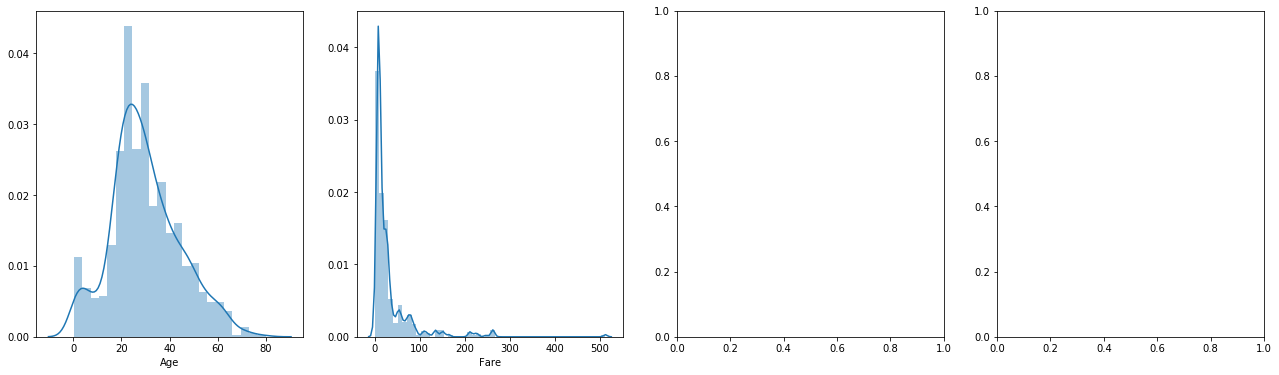

In [12]:
data_viz(full, numc_cols, type='hist')

In [13]:
# data_viz(full, catg_cols)

In [14]:
# data_viz(full,['Sex', 'Embarked', 'Pclass'], target='Survived', type='cross_tab')

## Feature Engineering

### 1. Handling missing values
    1. arbitrary imp
    2. random sample imputation
    3. frequent category imp
    4. end of distribution imp
    5. creating new feature
    6. mean/median/mode/count

In [15]:
# there should be a better way(look for it)
for col in full.columns.tolist(): 
    if(full[col].isna().mean()>0):
        print(col + ' - ' + str(round(full[col].isna().mean()*100, 2)))

print(train['Survived'].isna().mean()*100) 
#interesting. train has no nan for target variuable but test has 31.9% nan

Age - 20.09
Fare - 0.08
Cabin - 77.46
Embarked - 0.15
0.0


In [16]:
# as missing % is very less
full['Fare'].fillna(full['Fare'].median(), inplace=True)
full['Embarked'].fillna(full['Embarked'].mode()[0], inplace=True)

In [17]:
full['cabin_null'] = np.where(full['Cabin'].isna(), 1, 0)
full['Age_null'] = np.where(full['Age'].isna(), 1, 0)

In [18]:
print(full[full['Age'].isna()]['Cabin'].isna().mean()*100) #nunique(dropna=False)
#if Age is NA then 91% of cabin NA

print(full[full['Cabin'].isna()]['Age'].isna().mean())
# If Cabin is NA then 23.6% of Age is NA

91.25475285171103
0.23668639053254437


In [19]:
# data_viz(full, ['Age'], type='box')

In [20]:
full['Age'].fillna(-1, inplace=True)
bins = [-2,0,21,41,61,81,100]
labels=[0,1,2,3,4,5]
full['Age_binned'] = pd.cut(full['Age'], bins=bins, labels=labels)

In [21]:
full['Age_binned'].value_counts()

2    543
1    290
0    263
3    186
4     27
5      0
Name: Age_binned, dtype: int64

In [22]:
full['Cabin'].sort_values().unique()

array(['A10', 'A11', 'A14', 'A16', 'A18', 'A19', 'A20', 'A21', 'A23',
       'A24', 'A26', 'A29', 'A31', 'A32', 'A34', 'A36', 'A5', 'A6', 'A7',
       'A9', 'B10', 'B101', 'B102', 'B11', 'B18', 'B19', 'B20', 'B22',
       'B24', 'B26', 'B28', 'B3', 'B30', 'B35', 'B36', 'B37', 'B38',
       'B39', 'B4', 'B41', 'B42', 'B45', 'B49', 'B5', 'B50',
       'B51 B53 B55', 'B52 B54 B56', 'B57 B59 B63 B66', 'B58 B60', 'B61',
       'B69', 'B71', 'B73', 'B77', 'B78', 'B79', 'B80', 'B82 B84', 'B86',
       'B94', 'B96 B98', 'C101', 'C103', 'C104', 'C105', 'C106', 'C110',
       'C111', 'C116', 'C118', 'C123', 'C124', 'C125', 'C126', 'C128',
       'C130', 'C132', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C28',
       'C30', 'C31', 'C32', 'C39', 'C45', 'C46', 'C47', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55 C57', 'C6', 'C62 C64', 'C65',
       'C68', 'C7', 'C70', 'C78', 'C80', 'C82', 'C83', 'C85', 'C86',
       'C87', 'C89', 'C90', 'C91', 'C92', 'C93', 'C95', 'C97', 'C99', 'D',
       'D

In [23]:
full['Cabin'].fillna('Other', inplace=True)

### 2. Handling Outliers
       1. IQR
       2. standard deviation 

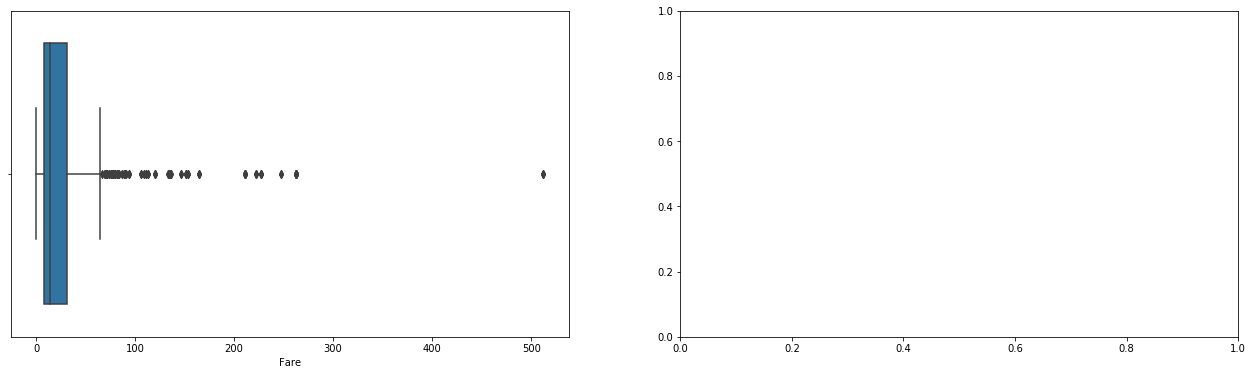

In [24]:
data_viz(full, ['Fare'], type='box')

### 3. Feature Generation

In [25]:
train[train['Fare']>=85]['Survived'].value_counts(normalize=True)

1    0.772727
0    0.227273
Name: Survived, dtype: float64

In [26]:
full['is_base_price'] = np.where(full['Fare']>=85, 1, 0)

In [44]:
full.head(1)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,is_train,cabin_null,Age_null,...,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_binned_0,Age_binned_1,Age_binned_2,Age_binned_3,Age_binned_4,Age_binned_5
0,1,0,3,22.0,1,0,7.25,1,1,0,...,1,0,0,1,0,0,1,0,0,0


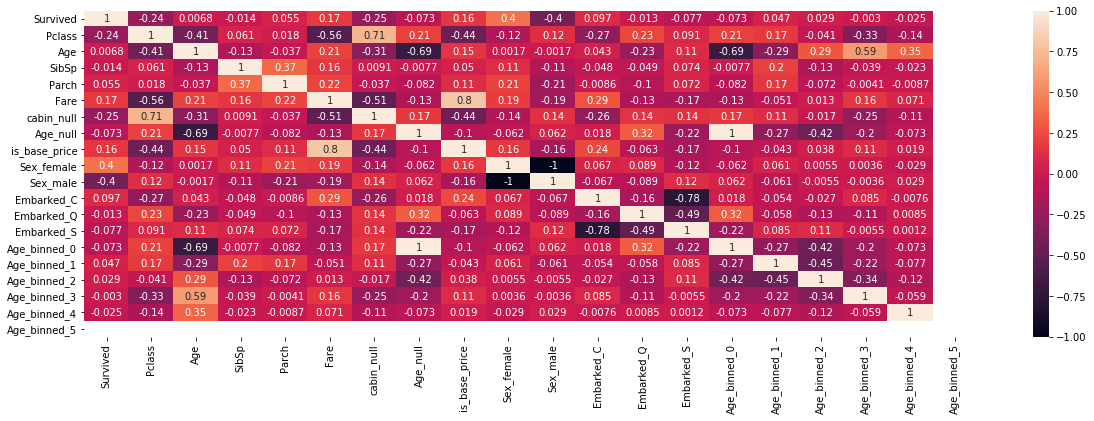

In [42]:
plt.figure(figsize=(20,6))
sns.heatmap(full.drop(['PassengerId', 'is_train'], axis=1).corr(), annot=True)

In [ ]:
drop_cols = ['Age']

## Encoding

In [28]:
# full.drop('PassengerId', axis=1, inplace=True)

In [29]:
drop_columns = ['Name', 'Ticket', 'Cabin']
full.drop(drop_columns, axis=1, inplace=True) # dropping for initial basic attempt

In [30]:
full = pd.get_dummies(full)

## train_test_split

In [31]:
train = full[full['is_train']==1]
test = full[full['is_train']==0]

train.drop('is_train', axis=1, inplace=True)
test.drop(['is_train', 'Survived'], axis=1, inplace=True)

In [32]:
y = train['Survived'].values
X = train.drop('Survived', axis=1)
# y.value_counts(normalize=True)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X.drop('PassengerId', axis=1), y, stratify=y, random_state=0)

## Hyper parameter optimization

In [34]:
space = {
    'n_estimators' : hp.choice('n_estimators', [100, 500, 1000, 1500, 2000]),
    'criterion' : hp.choice('criterion', ['entropy', 'gini']),
    'max_features': hp.choice('max_features', ['auto','sqrt', 'log2']),
    'max_depth': hp.choice('max_depth', [10,50]),
    'min_samples_split': hp.choice('min_samples_split', [1,2,3,5,8,13]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1,2])
}

In [35]:
def objective(space):
    model = XGBClassifier(n_estimators = space['n_estimators'],
                       criterion= space['criterion'],
                       max_features = space['max_features'],
                       max_depth = space['max_depth'],
                       min_samples_split = space['min_samples_split'],
                       min_samples_leaf = space['min_samples_leaf'])
    accuracy = cross_val_score(model, X_train, y_train, cv=5).mean()
    # we aim to maximize accuracy so we return negative value.
    return {'loss':-accuracy, 'status':STATUS_OK}

In [36]:
trials= Trials()
best_model = fmin(fn=objective,
                 space=space,
                 algo=tpe.suggest,
                 trials= trials,
                 max_evals=100)
best_model

 79%|███████▉  | 79/100 [04:37<01:13,  3.51s/trial, best loss: -0.821815733363259]


KeyboardInterrupt: 

In [ ]:
n_estimators = [100, 500, 1000, 1500, 2000]
criterion = ['entropy', 'gini']
max_features = ['auto','sqrt', 'log2']
max_depth = [10,50]
min_samples_split = [1,2,3,5,8,13]
min_samples_leaf = [1,2]

In [ ]:
model = XGBClassifier(n_estimators = n_estimators[best_model['n_estimators']],
                       criterion= criterion[best_model['criterion']],
                       max_features = max_features[best_model['max_features']],
                       max_depth = max_depth[best_model['max_depth']],
                       min_samples_split = min_samples_split[best_model['min_samples_split']],
                       min_samples_leaf = min_samples_leaf[best_model['min_samples_leaf']])

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_val)
accuracy_score(y_val, y_pred)

In [ ]:
y_pred = model.predict(test.drop('PassengerId', axis=1))

In [ ]:
data_object = {'PassengerId':test['PassengerId'], 'Survived':y_pred}
submission = pd.DataFrame(data_object)
submission.head(2)

In [ ]:
output = submission.to_csv('gender_submission.csv', index=False)